<a href="https://colab.research.google.com/github/chihoko12/plant_disease/blob/main/plant_disease_cu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

# Gathering Data

In [ ]:
urls = search_images_ddg('apple plant disease', max_images=100)
len(urls), urls[0]

(100,
 'https://www.spring-green.com/wp-content/uploads/2018/09/Apple-Scab-.jpg')

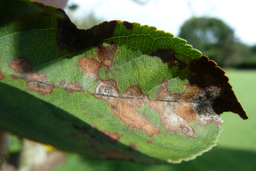

In [ ]:
download_url(urls[0],'images/apple_disease.jpg')
im = Image.open('images/apple_disease.jpg')
im.thumbnail((256,256))
im

In [ ]:
!pip install jmd_imagescraper

In [ ]:
from jmd_imagescraper.core import *
from pathlib import Path

In [ ]:
# the path where the picture is downloaded
path = '/../images'

In [ ]:
apple_disease_types = 'healthy','multiple_diseases','rust','scab'
path = Path(path)

In [ ]:
# create 4 folders and downloads 200 pictures into each of them
if not path.exists():
  path.mkdir()
  for o in apple_disease_types:
    dest = (path/o)
    duckduckgo_search(path,f'{o}',f'{o} apple leave', max_results=200)

In [ ]:
fns = get_image_files(path)
fns

(#800) [Path('/../images/scab/047_c4bf38bd.jpg'),Path('/../images/scab/090_3cb9812c.jpg'),Path('/../images/scab/159_b01ddd72.jpg'),Path('/../images/scab/063_0796e621.jpg'),Path('/../images/scab/001_a40101a4.jpg'),Path('/../images/scab/197_24470545.jpg'),Path('/../images/scab/148_6561fb76.jpg'),Path('/../images/scab/149_aa4fd751.jpg'),Path('/../images/scab/126_0648ed1c.jpg'),Path('/../images/scab/129_3c87cfd4.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink)

(#0) []

# From Data to DataLoaders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DataLoaders(GetAttr):
  def __int__(self, *loaders): self.loaders = loaders
  def __getitem(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [ ]:
apples = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = apples.dataloaders(path)

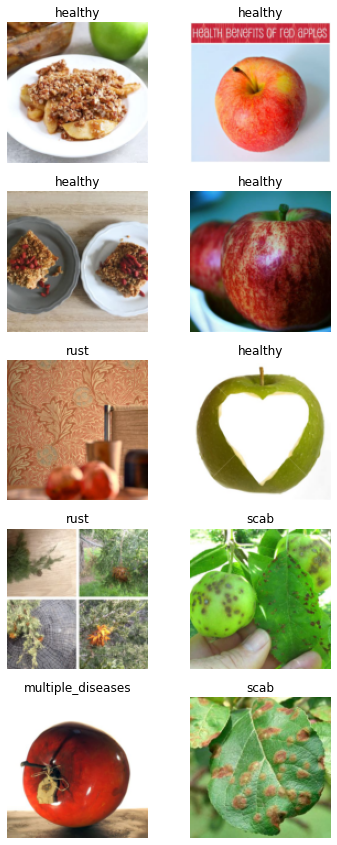

In [ ]:
dls.valid.show_batch(max_n=10, nrows=5)

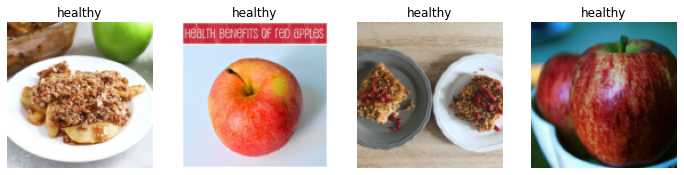

In [ ]:
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

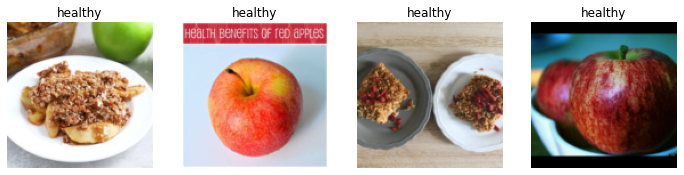

In [ ]:
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

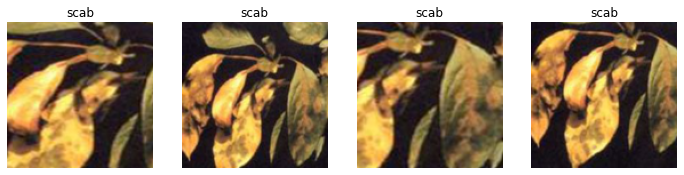

In [ ]:
apples = apples.new(item_tfms=RandomResizedCrop(128,min_scale=0.3))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

# Data Augumentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


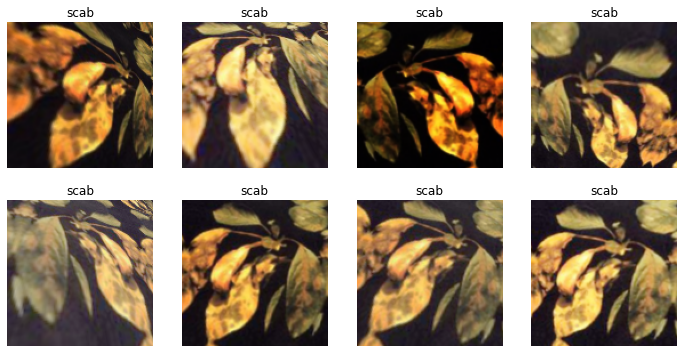

In [ ]:
apples = apples.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Training the Model and Using it to Clean the Data

In [ ]:
apples = apples.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = apples.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,2.032141,1.123292,0.306250,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.287061,0.893893,0.256250,00:10
1,1.047084,0.813779,0.262500,00:10
2,0.876281,0.812866,0.231250,00:10
3,0.745457,0.819099,0.225000,00:10


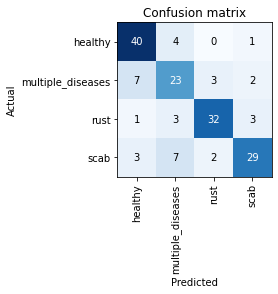

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

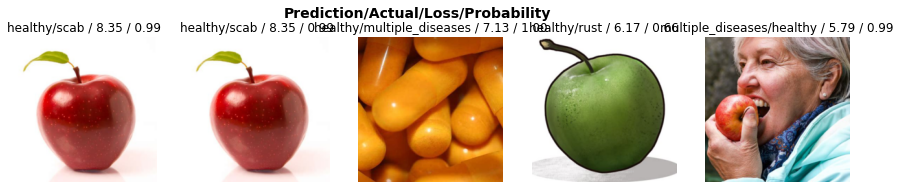

In [ ]:
interp.plot_top_losses(5,nrows=1)

In [ ]:
clearner = ImageClassifierCleaner(learn)

In [ ]:
# to delete (unlink) all images selected for deletion
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# to move images for which I've selected a different category
# for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]. path/cat))

# Using the Model for Inference

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/apple_disease.jpg')

('scab', tensor(3), tensor([5.0752e-05, 5.7908e-05, 6.0900e-02, 9.3899e-01]))

In [ ]:
learn_inf.dls.vocab

['healthy', 'multiple_diseases', 'rust', 'scab']

# Creating a Notebook App from the Model

In [ ]:
# file upload widget
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
btn_upload = SimpleNamespace(data=['images/apple_disease.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: scab; Probability: 0.9390')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.cleaner_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox = ([widgets.Label('Select your apple leave!'),
         btn_upload, btn_run, out_pl, lbl_pred])

# Turning the Notebook into a App

In [ ]:
!pip install voila
!jupyter serverextention enable --sys-prefix voila

Traceback (most recent call last):
  File "/usr/local/bin/jupyter", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 230, in main
    command = _jupyter_abspath(subcommand)
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 133, in _jupyter_abspath
    'Jupyter command `{}` not found.'.format(jupyter_subcommand)
Exception: Jupyter command `jupyter-serverextention` not found.
